# Scalability

The solution and estimation of finite-horizon discrete choice dynamic programming model appears straightforward. However, it entails a considerable computational burden due to the well known curse of dimensionality (Bellman and Dreyfus, 1962). The figure below illustrates how the total number of states increases exponentially with each period. The size of the state space is shown for Keane and Wolpin (1994) (all models have the same state space) and the base and extended model of Keane and Wolpin (1997). The latter two models are different because the state space of the base parameterization does not include information on the previous activity which significantly reduces the complexity of the model. Note that the y-axis us log-scaled to compensate for the loss in readibility due to exponential growth.

In [7]:
%load_ext nb_black
%matplotlib agg
import matplotlib.pyplot as plt
import pandas as pd
import respy as rp

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [8]:
plt.style.use("../_static/respy.mplstyle")

<IPython.core.display.Javascript object>

In [9]:
def _get_states_per_period(model):
    params, options, _ = rp.get_example_model(model)

    # This is not the official API, but we do only need the state space.
    state_space = rp.state_space.StateSpace(params, options)

    states_per_period = [
        len(range(slice_.start, slice_.stop))
        for slice_ in state_space.slices_by_periods
    ]

    return states_per_period

<IPython.core.display.Javascript object>

In [17]:
# models = ["kw_94_one", "kw_97_basic", "kw_97_extended"]

# container = {}

# for model in models:
#    container[model] = _get_states_per_period(model)

<IPython.core.display.Javascript object>

In [12]:
labels = [
    "Keane and Wolpin (1994)",
    "Keane and Wolpin (1997) - Base",
    "Keane and Wolpin (1997) - Extended",
]

fig, ax = plt.subplots()

for label, states_per_period in zip(labels, container.values()):
    n_states = sum(states_per_period)
    ax.semilogy(range(0, len(states_per_period)), states_per_period, label=label)

ax.set_ylim(1e0, 1e7)

ax.grid(which="both", axis="y")

ax.set_xlabel("Period")
ax.set_ylabel("Number of states")

ax.legend()

<IPython.core.display.Javascript object>

In [ ]:
fig

In total there are 317,367 states in Keane and Wolpin (1994), 12,991,208 states in Keane and Wolpin (1997) - Base and 59,306,140 states in Keane and Wolpin (1997) - Extended.

During an estimation, thousands of different candidate parameterizations of the model are appraised with respect to the sample likelihood. For each evaluation of the likelihood the $n$-dimensional integral of $E\max$ (where $n$ is the number of choices) needs to be approximated at all states. Below, we show the total computation time required for 1,000 evaluations of the criterion function as we increase the number of threads from two to twelve.

In [13]:
data = """
{"model": "kw_94_one", "maxfun": 50, "n_threads": 2, "start": "2019-08-26 17:38:29.779205", "end": "2019-08-26 17:39:50.248813", "duration": "0:01:20.469608"}
{"model": "kw_94_one", "maxfun": 50, "n_threads": 4, "start": "2019-08-26 17:40:12.377112", "end": "2019-08-26 17:41:07.376235", "duration": "0:00:54.999123"}
{"model": "kw_94_one", "maxfun": 50, "n_threads": 6, "start": "2019-08-26 17:41:29.312806", "end": "2019-08-26 17:42:20.699365", "duration": "0:00:51.386559"}
{"model": "kw_94_one", "maxfun": 50, "n_threads": 8, "start": "2019-08-26 17:42:42.730035", "end": "2019-08-26 17:43:29.568749", "duration": "0:00:46.838714"}
{"model": "kw_94_one", "maxfun": 50, "n_threads": 10, "start": "2019-08-26 17:43:52.496852", "end": "2019-08-26 17:44:39.377107", "duration": "0:00:46.880255"}
{"model": "kw_94_one", "maxfun": 50, "n_threads": 12, "start": "2019-08-26 17:45:01.743654", "end": "2019-08-26 17:45:44.754300", "duration": "0:00:43.010646"}
{"model": "kw_97_base", "maxfun": 3, "n_threads": 2, "start": "2019-08-26 17:53:53.999918", "end": "2019-08-26 17:56:09.303005", "duration": "0:02:15.303087"}
{"model": "kw_97_base", "maxfun": 3, "n_threads": 4, "start": "2019-08-26 17:59:03.115069", "end": "2019-08-26 18:00:26.045647", "duration": "0:01:22.930578"}
{"model": "kw_97_base", "maxfun": 3, "n_threads": 6, "start": "2019-08-26 18:03:18.388000", "end": "2019-08-26 18:04:26.720110", "duration": "0:01:08.332110"}
{"model": "kw_97_base", "maxfun": 3, "n_threads": 8, "start": "2019-08-26 18:07:14.577545", "end": "2019-08-26 18:08:12.402948", "duration": "0:00:57.825403"}
{"model": "kw_97_base", "maxfun": 3, "n_threads": 10, "start": "2019-08-26 18:10:57.492809", "end": "2019-08-26 18:11:49.910569", "duration": "0:00:52.417760"}
{"model": "kw_97_base", "maxfun": 3, "n_threads": 12, "start": "2019-08-26 18:14:32.824227", "end": "2019-08-26 18:15:22.644604", "duration": "0:00:49.820377"}
{"model": "kw_97_extended", "maxfun": 3, "n_threads": 2, "start": "2019-08-26 18:38:02.674008", "end": "2019-08-26 18:48:22.217274", "duration": "0:10:19.543266"}
{"model": "kw_97_extended", "maxfun": 3, "n_threads": 4, "start": "2019-08-26 19:05:13.122038", "end": "2019-08-26 19:11:25.247955", "duration": "0:06:12.125917"}
{"model": "kw_97_extended", "maxfun": 3, "n_threads": 6, "start": "2019-08-26 19:27:25.682803", "end": "2019-08-26 19:32:28.615169", "duration": "0:05:02.932366"}
{"model": "kw_97_extended", "maxfun": 3, "n_threads": 8, "start": "2019-08-26 19:48:37.839972", "end": "2019-08-26 19:53:05.588380", "duration": "0:04:27.748408"}
{"model": "kw_97_extended", "maxfun": 3, "n_threads": 10, "start": "2019-08-26 20:08:56.899445", "end": "2019-08-26 20:12:43.769137", "duration": "0:03:46.869692"}
{"model": "kw_97_extended", "maxfun": 3, "n_threads": 12, "start": "2019-08-26 20:27:47.747498", "end": "2019-08-26 20:31:26.824969", "duration": "0:03:39.077471"}
"""

<IPython.core.display.Javascript object>

In [14]:
df = pd.read_json(data, lines=True, convert_dates=["start", "end"])

# Get duration for 1000 evaluations.
df["duration"] = df.end - df.start
df["duration_1000_eval"] = 1000 / df["maxfun"] * df["duration"]

<IPython.core.display.Javascript object>

In [15]:
fig, ax = plt.subplots()

for label, group in df.groupby("model"):
    ax.semilogy(
        group.n_threads, group.duration_1000_eval.dt.total_seconds() / 60, label=label,
    )

ax.set_ylim(1e1, 1e4)

ax.grid(which="both", axis="y")

ax.set_xlabel("Number of threads")
ax.set_ylabel("Runtime (in Minutes)")

ax.legend(
    [
        "Keane and Wolpin (1994)",
        "Keane and Wolpin (1997) - Base",
        "Keane and Wolpin (1997) - Extended",
    ]
)

<IPython.core.display.Javascript object>

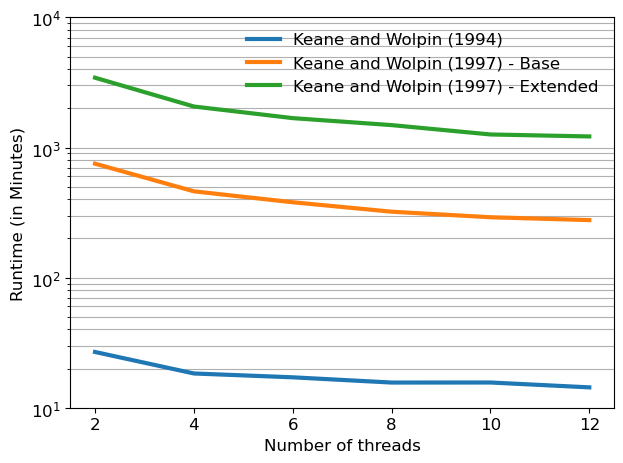

<IPython.core.display.Javascript object>

In [16]:
fig

Adding even more threads, however, does not lead to any further improvements.

For more details, see the script [online](https://github.com/OpenSourceEconomics/respy/blob/master/development/documentation/scalability/scalability_setup.py) or the complete Jupyter notebook in the repository under ``docs/software/scalability.ipynb``.